[08:26:50] Initializing Normalizer
[08:26:51] Molecule does not have explicit Hs. Consider calling AddHs()
[08:27:03] Initializing MetalDisconnector
[08:27:03] Running MetalDisconnector
[08:27:03] Initializing Normalizer
[08:27:03] Running Normalizer
[08:27:03] Running LargestFragmentChooser
[08:27:03] Initializing MetalDisconnector
[08:27:03] Running MetalDisconnector
[08:27:03] Initializing Normalizer
[08:27:03] Running Normalizer
[08:27:03] Running LargestFragmentChooser
[08:27:03] Explicit valence for atom # 6 C, 5, is greater than permitted
[08:27:03] Initializing MetalDisconnector
[08:27:03] Running MetalDisconnector
[08:27:03] Initializing Normalizer
[08:27:03] Running Normalizer
[08:27:03] Running LargestFragmentChooser


generation complete in 11.8


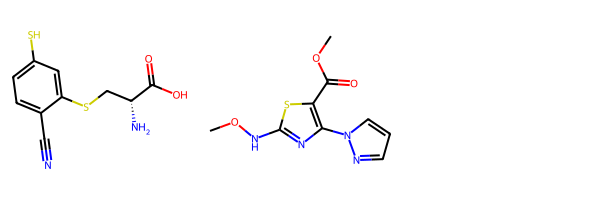

In [1]:
from ml_conformer_generator import MLConformerGenerator, evaluate_samples
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from rdkit.Chem import Draw
import time

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")
    
generator = MLConformerGenerator(device=device, diffusion_steps=100)

ref_mol = Chem.MolFromSmiles('Cc1cccc(N2CCC[C@H]2c2ccncn2)n1')
rdDistGeom.EmbedMolecule(ref_mol, forceTol=0.001, randomSeed=12)

# Generate Samples
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=4, variance=2)
print(f"generation complete in {round(time.time() - start, 2)}")

# Characterise samples   
_, std_samples = evaluate_samples(ref_mol, samples)
    
mols = []
for sample in std_samples:
    mol = Chem.MolFromMolBlock(sample['mol_block'])
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol.SetProp("Shape_Tanimoto", str(sample['shape_tanimoto']))
    mols.append(mol)
    
Draw.MolsToGridImage(mols)

In [2]:
from ml_conformer_generator import MLConformerGenerator, evaluate_samples
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from rdkit.Chem import Draw
import time
    
device = "mps:0"
generator = MLConformerGenerator(device=device, diffusion_steps=100)
generator.export_to_onnx()

[torch.onnx] Obtain model graph for `EGNNDynamics([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EGNNDynamics([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Obtain model graph for `AdjMatSeer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AdjMatSeer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


[11:29:30] Molecule does not have explicit Hs. Consider calling AddHs()
[11:29:52] Initializing MetalDisconnector
[11:29:52] Running MetalDisconnector
[11:29:52] Initializing Normalizer
[11:29:52] Running Normalizer
[11:29:52] Running LargestFragmentChooser
[11:29:52] Explicit valence for atom # 17 N, 4, is greater than permitted
[11:29:52] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:29:52] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 14 15 16


generation complete in 22.5


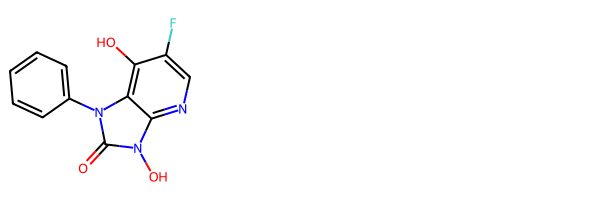

In [3]:
from ml_conformer_generator import MLConformerGeneratorONNX, evaluate_samples
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from rdkit.Chem import Draw
import time
    
device = "cpu"
generator = MLConformerGeneratorONNX(diffusion_steps=100)

ref_mol = Chem.MolFromSmiles('Cc1cccc(N2CCC[C@H]2c2ccncn2)n1')
rdDistGeom.EmbedMolecule(ref_mol, forceTol=0.001, randomSeed=12)

# Generate Samples
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=4, variance=2)
print(f"generation complete in {round(time.time() - start, 2)}")

# Characterise samples   
_, std_samples = evaluate_samples(ref_mol, samples)
    
mols = []
for sample in std_samples:
    mol = Chem.MolFromMolBlock(sample['mol_block'])
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol.SetProp("Shape_Tanimoto", str(sample['shape_tanimoto']))
    mols.append(mol)
    
Draw.MolsToGridImage(mols)

In [ ]:
import trimesh
from ml_conformer_generator import MLConformerGenerator, evaluate_samples
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from rdkit.Chem import Draw
import torch

mymesh = trimesh.load('./6q8k_pocket_a.stl')
mymesh.density = 0.02
check = mymesh.is_watertight
print(check)
ref_context = torch.tensor(mymesh.principal_inertia_components, dtype=torch.float32)

device = "cpu"
generator = MLConformerGenerator(device=device)



# Generate Samples
samples = generator.generate_conformers(reference_context=ref_context, n_atoms=27, n_samples=4, variance=12)

# Characterise samples   
# _, std_samples = evaluate_samples(ref_mol, samples)

mols = []
for i, sample in enumerate(samples):
    Chem.MolToMolFile(sample, f"./6q8k_gen_sample_{i}.mol")
    mol = sample
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mols.append(mol)

Draw.MolsToGridImage(mols)

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from rdkit.Chem import Draw

reader = Chem.SDMolSupplier("./31_39_6q8k_generated_molecules.sdf")
mols = []
for sample in reader:
    mol = sample
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mols.append(mol)

Draw.MolsToGridImage(mols)

